In [1]:
import os
import glob
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [4]:
#Choose output data to process
run = 'pi03'
years = [1850]
ds = xr.load_dataset(f"../data/ecefiles/{run}/ICMGG{run}+{years[0]}01",engine='cfgrib')

ds

<xarray.Dataset>
Dimensions:              (isobaricInhPa: 11, time: 124, values: 88838)
Coordinates:
    number               int64 0
  * time                 (time) datetime64[ns] 1850-01-01T06:00:00 ... 1850-0...
    step                 timedelta64[ns] 00:00:00
    surface              float64 0.0
    latitude             (values) float64 89.46 89.46 89.46 ... -89.46 -89.46
    longitude            (values) float64 0.0 20.0 40.0 ... 300.0 320.0 340.0
    valid_time           (time) datetime64[ns] 1850-01-01T06:00:00 ... 1850-0...
    depthBelowLandLayer  float64 0.0
  * isobaricInhPa        (isobaricInhPa) float64 1e+03 925.0 850.0 ... 50.0 10.0
Dimensions without coordinates: values
Data variables: (12/27)
    siconc               (time, values) float32 0.9956 0.995 0.9938 ... 0.0 0.0
    asn                  (time, values) float32 0.85 0.85 0.85 ... 0.8 0.8 0.8
    rsn                  (time, values) float32 100.0 100.0 ... 300.0 300.0
    sst                  (time, values) float32 271.3 271.3 ... 273.2 273.2
    istl1                (time, values) float32 248.1 248.9 ... 271.5 271.5
    es                   (time, values) float32 5.588e-09 ... 7.448e-06
    ...                   ...
    tcc                  (time, values) float32 1.0 1.0 1.0 ... 0.98 1.0 0.78
    u10                  (time, values) float32 2.845 4.402 ... -4.475 -4.012
    v10                  (time, values) float32 4.091 3.293 ... -1.078 -2.444
    t2m                  (time, values) float32 247.4 248.9 ... 243.9 244.0
    d2m                  (time, values) float32 244.6 246.3 ... 240.9 241.0
    fal                  (time, values) float32 0.819 0.8197 0.8202 ... 0.8 0.8
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-06-07T13:54 GRIB to CDM+CF via cfgrib-0.9.9...

In [2]:
run = 'fx02'
years = np.arange(1850,1852)

rho = 1000
months = np.arange(1,13)

#Prepare diagnostic variables
SF   = np.zeros((len(years),len(months)))
SFex = np.zeros((len(years),len(months)))
MLT  = np.zeros((len(years),len(months)))
EVP  = np.zeros((len(years),len(months)))
Res  = np.zeros((len(years),len(months)))

#Read generic IFS data
ds = xr.open_dataset('../data/ecefiles/areas.nc')
area = ds['A128.srf'].values
ds.close()
ds = xr.load_dataset(f"../data/ecefiles/{run}/ICMGG{run}+{years[0]}01",engine='cfgrib')
lon = ds['longitude'].values
lat = ds['latitude'].values
ds.close()
mask = np.where(lat<-60,1,0)

#Extract diagnostics
for y,yy in enumerate(years):
    for m,mm in enumerate(months):
        fname = f"../data/ecefiles/{run}/ICMGG{run}+{yy}{mm:02d}"
        ds = xr.load_dataset(fname,engine='cfgrib')
        time = ds.time.values
        sf = ds.sf.values
        sd = ds.sd.values
        mlt = ds.smlt.values
        evp = ds.es.values
        ds.close()
        
        SF[y,m]   = np.nansum(sf*np.where(sd>0,1,0)*mask*area*rho*1e-12)
        SFex[y,m] = np.nansum(sf*np.where(sd==10,1,0)*mask*area*rho*1e-12)
        MLT[y,m]  = np.nansum(mlt*np.where(sd>0,1,0)*mask*area*rho*1e-12)
        EVP[y,m]  = np.nansum(evp*np.where(sd>0,1,0)*mask*area*rho*1e-12)
        
        Res[y,m]  = SF[y,m] - SFex[y,m] - MLT[y,m] + EVP[y,m]

        #print(f'Got {yy} {mm}')
    print(f'{yy}: SF: {np.sum(SF[y,:]):.0f} | SFex: {np.sum(SFex[y,:]):.0f} | MLT: {np.sum(MLT[y,:]):.0f} | EVP: {np.sum(EVP[y,:]):.0f} | Res: {np.sum(Res[y,:]):.0f} Gt/yr')    

Got 1850 1
Got 1850 2
Got 1850 3
Got 1850 4
Got 1850 5
Got 1850 6
Got 1850 7
Got 1850 8
Got 1850 9
Got 1850 10


Ignoring index file '/Users/erwin/projects/KPZ/data/ecefiles/fx02/ICMGGfx02+185012.923a8.idx' older than GRIB file


Got 1850 11
Got 1850 12
1850: SF: 3651 | SFex: 3021 | MLT: 346 | EVP: -246 | Res: 38 Gt/yr
Got 1851 1
Got 1851 2
Got 1851 3
Got 1851 4
Got 1851 5
Got 1851 6
Got 1851 7
Got 1851 8
Got 1851 9
Got 1851 10
Got 1851 11
Got 1851 12
1851: SF: 3198 | SFex: 2580 | MLT: 384 | EVP: -281 | Res: -48 Gt/yr


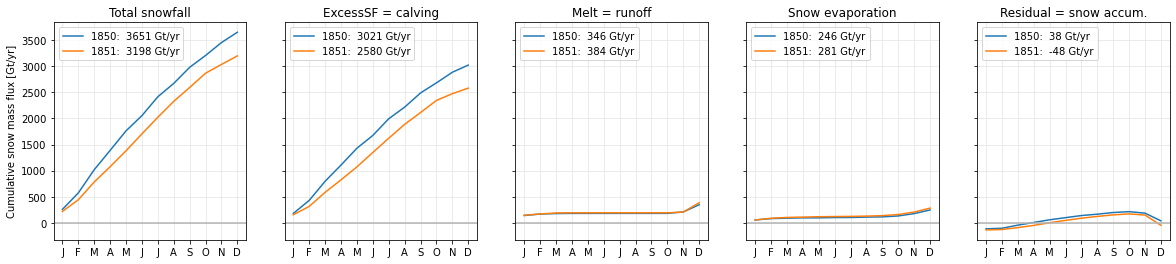

In [5]:
#Merge diagnostics into single variable
var = {}
var[0] = SF
var[1] = SFex
var[2] = MLT
var[3] = -EVP
var[4] = Res

title = ['Total snowfall','Excess snowfall','Snow melt','Snow evaporation','Residual = snow accum.']
fig,ax = plt.subplots(1,5,figsize=(20,4),sharey=True)

for v in range(5):
    for y,yy in enumerate(years):
        ax[v].plot(np.cumsum(var[v][y,:]),label=f'{yy}:  {np.sum(var[v][y,:]):.0f} Gt/yr')
    ax[v].set_title(title[v])
    ax[v].set_xticks(np.arange(12));
    ax[v].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D']);
    ax[v].legend(loc='upper left')
    ax[v].grid(True,color='.9')
    ax[v].axhline(0,0,1,color='.7')
    
ax[0].set_ylabel('Cumulative snow mass flux [Gt/yr]')
plt.savefig(f'../figures/snowfall_budget.png',dpi=450)
plt.show()

In [4]:
for v in range(5):
    print(f"{title[v]:20}: {np.mean(np.sum(var[v],axis=1)):4.0f} ({np.std(np.sum(var[v],axis=1)):3.0f}) Gt/yr")

Total snowfall      : 3424 (227) Gt/yr
ExcessSF = calving  : 2801 (221) Gt/yr
Melt = runoff       :  365 ( 19) Gt/yr
Snow evaporation    :  264 ( 18) Gt/yr
Residual/snow accum.:   -5 ( 43) Gt/yr
